In [32]:
import torchvision
import torch
import matplotlib.pyplot as plt
import numpy as np
from IPython.display import display, clear_output
import ipywidgets as widgets


In [2]:
# Transform pipeline: The data that comes back is in PIL image format. We want to transform
# it into normalized tensors for later computation
transform_pipeline = torchvision.transforms.Compose([torchvision.transforms.ToTensor()])

# Set up the data sources
train_data = torchvision.datasets.MNIST('data/', train=True, download=True, transform=transform_pipeline)
test_data = torchvision.datasets.MNIST('data/', train=False, download=True, transform=transform_pipeline)

# Set up data loaders (samplers + the data set)
train_loader = torch.utils.data.DataLoader(train_data, batch_size=128, shuffle=True)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=64, shuffle=True)

In [3]:
# Let's take a look at what's in the dataset

# First, some utilities for interacting with tensors. Tensors are just a string of numbers. Here we want
# to have a way of actually showing them.
def display_tensor(tensor):
    """Displays a tensor using matplotlib"""
    plt.imshow(tensor.view(28, 28),  cmap='gray', interpolation='none')

(tensor([[[0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000,
          0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000

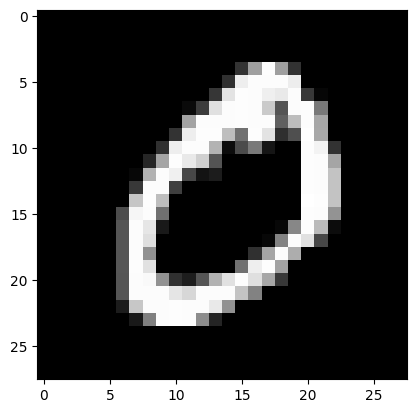

In [4]:
# Now, let's take a look at a single data point
data = train_data[1]
print(data) # Display the raw data (tensor, label)
display_tensor(data[0][0]) # View the tensor

Data size: torch.Size([128, 1, 28, 28])
Label: tensor(4)


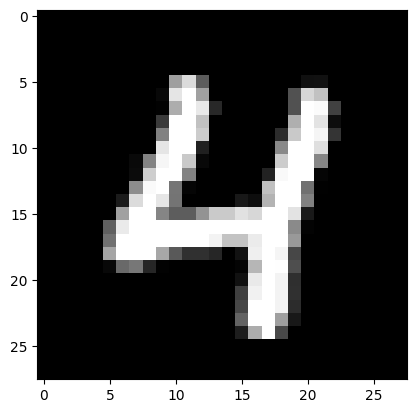

In [5]:
# What is a data loader? A data set + a way of sampling that dataset.
# Also helps with some performance around multi process loading
_, batch = next(enumerate(train_loader))
print("Data size:", batch[0].shape) # See all of the data in the set
display_tensor(batch[0][0]) # See the tensor
print("Label:", batch[1][0]) # See the label

In [6]:
class Autoencoder(torch.nn.Module):
    """Simple, single hidden layer, linear auto-encoder"""
    def __init__(self, input_shape, latent_size, hidden_size=128):
        super().__init__()
        self.encoder_hidden = torch.nn.Linear(in_features=input_shape, out_features=hidden_size)
        self.encoder_output = torch.nn.Linear(in_features=hidden_size, out_features=latent_size)

        self.decoder_hidden = torch.nn.Linear(in_features=latent_size, out_features=hidden_size)
        self.decoder_output = torch.nn.Linear(in_features=hidden_size, out_features=input_shape)

        
    def encode(self, x):
        """Encode using the encoder portion of the auto encoder."""
        x = self.encoder_hidden(x)
        x = torch.relu(x)
        x = self.encoder_output(x)
        return x
    
    def decode(self, x):
        """Decode using the decoder portion of the auto encoder."""
        x = self.decoder_hidden(x)
        x = torch.relu(x)
        x = self.decoder_output(x)
        x = torch.sigmoid(x)
        return x
        
    def forward(self, x):
        """Run the entire auto encoder/decoder pair together."""
        code = self.encode(x)
        reconstructed = self.decode(code)
        return reconstructed

In [7]:
epochs = 20 # How many times we'll be training
model = Autoencoder(input_shape=28*28, latent_size=2, hidden_size=128).cuda()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3) 
criterion = torch.nn.MSELoss()

In [8]:
for epoch in range(epochs):
    loss = 0
    for i, (batch_features, _) in enumerate(train_loader):
        batch_features = batch_features.view(-1, 784).cuda() # Reshape into a flat list
        optimizer.zero_grad()
        outputs = model(batch_features) # See what the model would predict
        train_loss = criterion(outputs, batch_features) # Compute loss
        train_loss.backward() # Run back prop on the loss
        optimizer.step() # Update the parameters
        loss += train_loss.item() # Aggregate for metrics
        
    loss = loss / len(train_loader)
    print("epoch : {}/{}, loss = {:.6f}".format(epoch + 1, epochs, loss))

epoch : 1/20, loss = 0.062871
epoch : 2/20, loss = 0.051653
epoch : 3/20, loss = 0.050042
epoch : 4/20, loss = 0.048661
epoch : 5/20, loss = 0.047570
epoch : 6/20, loss = 0.046634
epoch : 7/20, loss = 0.045834
epoch : 8/20, loss = 0.045246
epoch : 9/20, loss = 0.044757
epoch : 10/20, loss = 0.044365
epoch : 11/20, loss = 0.044013
epoch : 12/20, loss = 0.043695
epoch : 13/20, loss = 0.043390
epoch : 14/20, loss = 0.043126
epoch : 15/20, loss = 0.042898
epoch : 16/20, loss = 0.042672
epoch : 17/20, loss = 0.042491
epoch : 18/20, loss = 0.042302
epoch : 19/20, loss = 0.042132
epoch : 20/20, loss = 0.041985


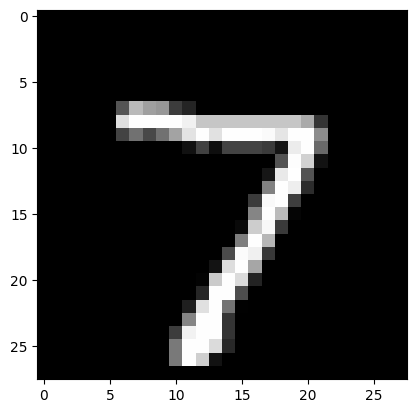

In [17]:
# Let's pull some data
data, _ = test_data[0]
display_tensor(data[0])

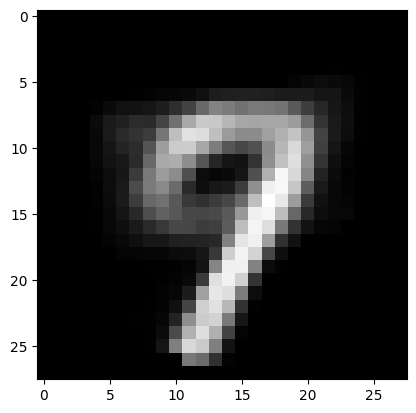

In [18]:
# Now let's see what the model says
model_output = model(data.view(-1, 28 * 28).cuda())
display_tensor(model_output.cpu().detach())

In [50]:
def plot_latent(autoencoder, data, num_batches=100):
    """Plot the latent space of data"""
    for i, (x, y) in enumerate(data):
        z = autoencoder.encode(x.view(-1, 28 * 28).cuda())
        z = z.cpu().detach().numpy()
        plt.scatter(z[:, 0], z[:, 1], c=y, cmap='tab10')
        if i > num_batches:
            break
    plt.colorbar()
            
def plot_reconstructed(autoencoder, r0=(-5, 15), r1=(-5, 30), n=12):
    """Plot a reconstructed space of the model"""
    w = 28
    img = np.zeros((n*w, n*w))
    for i, y in enumerate(np.linspace(*r1, n)):
        for j, x in enumerate(np.linspace(*r0, n)):
            z = torch.Tensor([[x, y]]).cuda()
            x_hat = autoencoder.decode(z)
            x_hat = x_hat.reshape(28, 28).cpu().detach().numpy()
            img[(n-1-i)*w:(n-1-i+1)*w, j*w:(j+1)*w] = x_hat
    return img
#     plt.imshow(img, extent=[*r0, *r1])

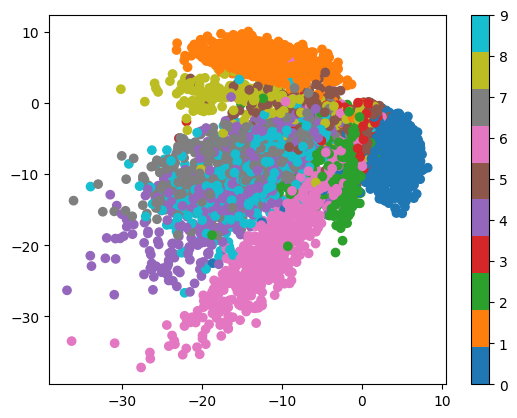

In [53]:
plot_latent(model, test_loader, num_batches=100)

In [54]:
@widgets.interact(x=(-30, 10), y=(-10,10))
def plot(x, y):
    img = plot_reconstructed(model, (x - 5, x + 5), (y - 5, y + 5))
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))
    ax.imshow(img)

interactive(children=(IntSlider(value=-10, description='x', max=10, min=-30), IntSlider(value=0, description='…